In [1]:
import torch
import os
import sys
import pdb
import argparse
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
from pyannote.audio import Pipeline
from pyannote.audio.pipelines.utils.hook import ProgressHook
from pyannote.audio.pipelines.clustering import AgglomerativeClustering
from custom_speaker_embedding import MyCustomSpeakerEmbedding

from analyse_audio import load_model, get_df_diarization, filter_main_singer

/home/brendanoconnor/miniforge3/envs/voicebioservice-pyannoteaudio/lib/python3.11/site-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/brendanoconnor/miniforge3/envs/voicebioservice-pyannoteaudio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to import Flash Attention, using ESPnet default: No module named 'flash_attn'
2026-01-15 21:57:07,508 - voice_bio_service.download - INFO - Logging configured with handlers: stdout
2026-01-15 21:57:07,509 - voice_bio_service.rawnet3 - INFO - Logging configured with handlers: stdout
2026-01-15 21:57:07,545 - voice_bio_service.ingest - INFO - Logging configured with handlers: stdout
2026-01-15 21:57:07,548 - voice_bio_service.infer - INFO - Logging configured with handlers: stdout


In [ ]:
class Object():
    pass

args = Object()
args.ds_path = "../gs_imports/diarization_subset/heavily processed/2 unlimited - no limit.wav"
args.custom_model_path = "../model_ckpts/RawNet3/12m-trained-deployed-rawnet3/58epoch.pth"
args.min_seg_dur = 0.5

In [12]:
ds_path = args.ds_path
pipeline = load_model(custom_model_path=args.custom_model_path)
if os.path.isdir(ds_path):
    file_list = [os.path.join(ds_path, f) for f in os.listdir(ds_path) if f.endswith(".wav") and not f.startswith(".") and not os.path.isdir(os.path.join(ds_path, f))]
elif os.path.isfile(ds_path):
    file_list = [ds_path]
    ds_path = os.path.dirname(ds_path)
else:
    raise ValueError(f"Invalid dataset path: {ds_path}")    

diar_csvs_dir = os.path.join(ds_path, "single_singer_diarizations")
os.makedirs(diar_csvs_dir, exist_ok=True)
y, sr = librosa.load(args.ds_path, sr=None)

# Output directory for singer audio files
audio_out_dir = os.path.join(".", "singer_extracts")
os.makedirs(audio_out_dir, exist_ok=True)

for audio_path in file_list:
    track_name = os.path.splitext(os.path.basename(audio_path))[0]
    dst_csv_path = os.path.join(diar_csvs_dir, f"{track_name}.csv")
    df = get_df_diarization(pipeline, audio_path)
    singleclass_segments = filter_main_singer(df, min_seg_dur=args.min_seg_dur, verbose=True)
    singleclass_segments.to_csv(dst_csv_path, index=False)
    print(f"Saved singleclass segments to {dst_csv_path}")

    singer_ids = list(singleclass_segments['speaker_class'].unique())
    for singer_id in singer_ids:
        chunks = [
            {"start": s, "end": e}
            for s, e in zip(
                singleclass_segments["start_time"],
                singleclass_segments["stop_time"]
            )
        ]
        # Extract and concatenate all chunks for this singer
        audio_segments = []
        for chunk in chunks:
            start_sample = int(chunk['start'] * sr)
            end_sample = int(chunk['end'] * sr)
            audio_segments.append(y[start_sample:end_sample])
        
        # Concatenate all segments
        concatenated_audio = np.concatenate(audio_segments)

        # Save to disk
        output_path = os.path.join(audio_out_dir, f"{singer_id}.wav")
        sf.write(output_path, concatenated_audio, sr) 

2026-01-15 22:19:11,528 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/pyannote/speaker-diarization-community-1/resolve/main/config.yaml "HTTP/1.1 200 OK"
2026-01-15 22:19:11,597 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/pyannote/speaker-diarization-community-1/resolve/main/segmentation/pytorch_model.bin "HTTP/1.1 302 Found"


2026-01-15 22:19:11,743 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/pyannote/speaker-diarization-community-1/resolve/main/plda/xvec_transform.npz "HTTP/1.1 302 Found"
2026-01-15 22:19:11,810 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/pyannote/speaker-diarization-community-1/resolve/main/plda/plda.npz "HTTP/1.1 302 Found"
2026-01-15 22:19:12,023 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/pyannote/speaker-diarization-community-1/resolve/main/embedding/pytorch_model.bin "HTTP/1.1 302 Found"
2026-01-15 22:19:12,325 - httpx - INFO - HTTP Request: GET https://huggingface.co/api/models/espnet/voxcelebs12_rawnet3/revision/main "HTTP/1.1 200 OK"


Fetching 24 files: 100%|██████████| 24/24 [00:00<00:00, 148690.25it/s]

2026-01-15 22:19:12,336 - root - INFO - config file: /home/brendanoconnor/miniforge3/envs/voicebioservice-pyannoteaudio/lib/python3.11/site-packages/espnet_model_zoo/models--espnet--voxcelebs12_rawnet3/snapshots/e107eac2ecb73dafcf6fd48af13c74f8ea2f5e2c/save_exp/spk_train_rawnet3_best_trnVox12_emb192_amp_subcentertopk_raw_sp/config.yaml



Using cache found in /home/brendanoconnor/.cache/torch/hub/snakers4_silero-vad_v4.0


/home/brendanoconnor/miniforge3/envs/voicebioservice-pyannoteaudio/lib/python3.11/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

2026-01-15 22:19:14,319 - root - INFO - speech length: 26078


/home/brendanoconnor/miniforge3/envs/voicebioservice-pyannoteaudio/lib/python3.11/site-packages/espnet2/asr/fronten
d/asteroid_frontend.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 
`torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):

2026-01-15 22:19:14,342 - root - INFO - speech length: 26078
2026-01-15 22:19:14,351 - root - INFO - speech length: 26078
2026-01-15 22:19:14,361 - root - INFO - speech length: 26078
2026-01-15 22:19:14,369 - root - INFO - speech length: 26078
2026-01-15 22:19:14,378 - root - INFO - speech length: 26078
2026-01-15 22:19:14,387 - root - INFO - speech length: 26078
2026-01-15 22:19:14,396 - root - INFO - speech length: 26078
2026-01-15 22:19:14,406 - root - INFO - speech length: 26078
2026-01-15 22:19:14,416 - root - INFO - speech length: 26078
2026-01-15 22:19:14,426 - root - INFO - speech length: 26078
2026-01-15 22:19:14,435 - root - INFO - speech length: 26078
2026-01-15 22:19:14,444 - root - INFO - speech length: 26078
2026-01-15 22:19:14,453 - root - INFO - speech length: 26078
2026-01-15 22:19:14,461 - root - INFO - speech length: 26078
2026-01-15 22:19:14,470 - root - INFO - speech length: 26078
2026-01-15 22:19:14,478 - root - INFO - speech length: 26078
2026-01-15 22:19:14,487 

Original segments: 11
After removing < 0.5s: 10
Removed: 1 short segments
Initially found 0 overlapping segments
Multiclass segments >= 0.5s: 0
Singleclass segments: 10
Saved singleclass segments to /home/brendanoconnor/gs_imports/diarization_subset/heavily processed/single_singer_diarizations/2 unlimited - no limit.csv


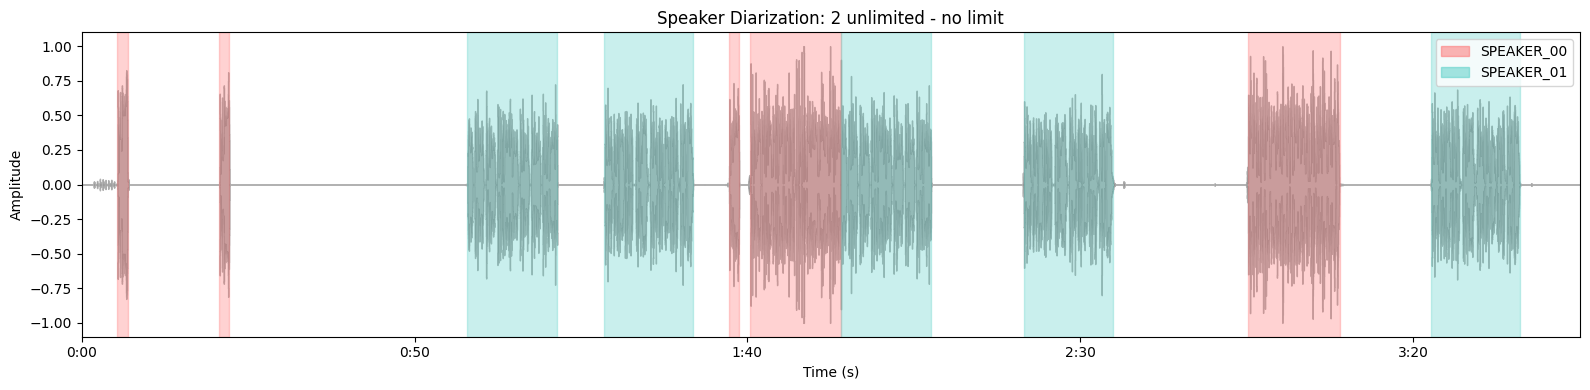

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa.display

duration = librosa.get_duration(y=y, sr=sr)

# Create figure with waveform
fig, ax = plt.subplots(figsize=(16, 4))
librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.6, color='gray')

# Define colors for each speaker
speaker_colors = {
    'SPEAKER_00': '#FF6B6B',  # coral red
    'SPEAKER_01': '#4ECDC4',  # teal
    'SPEAKER_02': '#FFE66D',  # yellow
    'SPEAKER_03': '#95E1D3',  # mint
}

# Overlay colored segments for each speaker
for _, row in singleclass_segments.iterrows():
    speaker = row['speaker_class']
    color = speaker_colors.get(speaker, '#888888')
    ax.axvspan(row['start_time'], row['stop_time'], 
               alpha=0.3, color=color, label=speaker)

# Create legend (deduplicated)
handles = [mpatches.Patch(color=color, alpha=0.5, label=speaker) 
           for speaker, color in speaker_colors.items() 
           if speaker in singleclass_segments['speaker_class'].values]
ax.legend(handles=handles, loc='upper right')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Speaker Diarization: {track_name}')
ax.set_xlim(0, duration)

plt.tight_layout()
plt.savefig(f'{track_name}_diarization.png')
plt.show()
plt.close()